# Lexical Category Analysis with LIWC
A way to analyze any DTRS dataset using lexical categories from LIWC.
Uses the liwc library, [install from GitHub](https://github.com/evanll/liwc-text-analysis-python)

In [1]:
import sys
import re
import glob
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import Markdown, display
from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups

In [2]:
def printmd(string):
    display(Markdown(string))

## Load DTRS datasets
Load pre-processed DTRS datasets into a dataframe

In [3]:
files = glob.glob('./output/*.txt')

df_list = []

for filename in files:
    df_file = pd.read_csv(filename, sep=';')
    df_list.append(df_file)

df = pd.concat(df_list, axis=0, ignore_index=True)
print("Read", len(files), "files and loaded", df.shape[0], "rows into the dataframe.")

Read 65 files and loaded 20902 rows into the dataframe.


In [4]:
df[0:10]

,dataset,session,speaker,utterance
0,dtrs-10,grad-2-concept-review-sharon,Steve,Next. Okay whose turn? Wilson?
1,dtrs-10,grad-2-concept-review-sharon,Wilson,Huh?
2,dtrs-10,grad-2-concept-review-sharon,Steve,"You’re talking, it’s your turn."
3,dtrs-10,grad-2-concept-review-sharon,Wilson,It’s my turn?
4,dtrs-10,grad-2-concept-review-sharon,Steve,You critique it. What’s working. Explain the...
5,dtrs-10,grad-2-concept-review-sharon,Wilson,Let me take a look. Uh. So it is uh a coat h...
6,dtrs-10,grad-2-concept-review-sharon,Steve,"OK. It makes sense. Okay, what is good about..."
7,dtrs-10,grad-2-concept-review-sharon,Wilson,I think the storyboard it make very good sense.
8,dtrs-10,grad-2-concept-review-sharon,Steve,Okay.
9,dtrs-10,grad-2-concept-review-sharon,Wilson,Yes.


## Extract List of Terms from LIWC
The list below is a placeholder. Ideally we would like to replace the list below with a list of category terms from LIWC.

In [5]:
liwc_test = ["swim", "walk", "paddle", "ride", "crawl", "scoot", "paddling",
     "drag", "swim", "waddle", "gallop", "jump", "Swim", "feet", "fly",
     "pedal", "trail", "skate", "slip", "haul", "slide", "jog", "jog",
     "crawl", "climb_trees", "chase", "walk", "faceplant", "boat",
     "catch", "knuckle", "riding", "hike", "fling", "uphill",
     "snowboard", "swimming", "long_board", "float", "hop", "sprint",
     "raft", "bonk", "hike", "walk/run", "dismount", "mosey", "limp",
     "train", "scurry", "whack", "ditch", "skateboard", "duck", "kayak",
     "huck", "ski", "saunter", "wheel", "dart", "paddling", "sideways",
     "sail", "plow", "yank", "fly", "loaf", "dive", "head", "drive",
     "legs", "kayak", "town", "lumber", "lay", "step", "skateboard",
     "hump", "sit", "climb", "shimmy", "pound", "scoot", "trail", "zip",
     "soft_sand", "long_ride", "feet", "glide", "trudge", "deep_water",
     "skid", "strap", "beach", "putter", "maneuver"]

liwc_tentative = ["pretty", "confused", "hesitant", "hopefully", "confusing", "hoping",
    "doubt", "doubting", "hope", "confuse", "hoped", "luck", "lucky", "any",
    "questions", "kind of", "probably", "something", "or", "anything",
    "may", "some", "try", "perhaps", "if", "possible", "bet", "guess",
    "anyhow", "most", "quite", "might", "sort", "somewhat", "assuming",
    "supposed", "seem", "somebody", "maybe", "someone", "assume", "trying",
    "lot", "question", "sometimes", "option", "dunno", "approximately",
    "sorta", "generally", "options", "possibility", "kinda", "kind of", "overall",
    "seems", "wondering", "somewhere", "sometime", "assumption",
    "potentially", "possibly", "optional", "optionally", "mostly", "almost",
    "depending", "often", "seemed", "potential", "temporarily",
    "occasionally", "wonder", "someone's", "lots", "opinion", "apparently",
    "somehow", "somebody's", "suppose", "barely", "usually", "random",
    "vary", "anywhere", "puzzle", "practically", "fairly", "wondered",
    "depends", "appears", "unknown", "assumed", "probablyâ", "unlikely",
    "mainly", "something's", "vaguely", "sorts", "theory", "chance",
    "typically", "possibleâ", "confusion", "virtually", "anyone",
    "appearing", "depend", "anybody", "likely", "unclear", "supposing",
    "possibilities", "appear", "alot", "border", "assumes", "guessing",
    "hardly", "anytime", "temporary", "randomly", "lotta", "hypothetical",
    "contingent", "someday", "undecided", "hypothesize", "blurred",
    "variable", "theoretically", "partly", "borderline", "variables",
    "feasible", "confusions", "somethingo", "mystery", "questioning",
    "assumptions", "possibilites", "betting", "indirectly", "supposedly",
    "varies", "vague", "vaguely", "temporally", "indirect", "puzzling"]

liwc_approx_vague = ["vaguely", "kinda", "kind of", "sorta", "somewhat" ]
liwc_possibility = ["if", "maybe", "might", "perhaps", "possibly", "probably"]

liwc_tentative_groups = [
    { "group" : "approx-moderate",
      "words" : [ "approximately", "partly", "most", "often",
                  "occasionally", "sometimes", "mainly", "mostly",
                  "generally", "typically", "usually" ] 
    },
    { "group" : "approx-extreme",
      "words" : [ "barely", "hardly", "almost", "practically", "virtually", "fairly", "pretty", "quite"]
    },
    { "group" : "approx-vague",
      "words" : ["vaguely", "kinda", "kind of", "sorta", "somewhat" ]
    },
    { "group" : "quantity",
      "words" : [ "alot", "lot", "lots", "some", "sort", "sorts" ] 
    },
    { "group" : "pronoun-indef",
      "words" : [ "any", "anybody", "anyone", "anything", "anytime",
                  "anywhere", "or", "somebody", "somebody's", "someone",
                  "someone's", "something", "somethingo", "something's", "somewhere" ]
    },
    { "group" : "ostension",
      "words" : [ "anyhow", "apparently", "appears", "dunno", "seem",
                  "seemed", "seems", "somehow", "supposedly" ] 
    },
    { "group" : "possibility",
      "words" : [ "if", "maybe", "might", "perhaps", "possibly",
                  "probably", "probablyâ" ] # last one is a typo in the dataset
    },
    { "group" : "hypothesis",
      "words" : [ "assumption", "assumptions", "hypothesize",
                  "hypothetical", "theory"] 
    },
    { "group" : "speculation",
      "words" : [ "doubt", "wonder", "wondered", "wondering" ]
    },
    { "group" : "assumption",
      "words" : [ "assume", "assumed", "assumes", "assuming", "guess",
                  "guessing", "suppose", "supposed", "supposing"] },
    { "group" : "aspiration",
      "words" : [ "hope", "hoped", "hopefully", "hoping", "may",
                  "someday", "sometime", "potentially", "theoretically",
                  "likely", "unlikely"]
    },
    { "group" : "feasibility",
      "words" : [ "chance", "feasible", "possibilities", "possibility",
                  "possibilites", "possibleâ", # typos present in the dataset? 
                  "possible", "potential", "try", "trying"] 
    },
    { "group" : "contingence",
      "words" : [ "contingent", "depend", "depending", "depends",
                  "option", "optional", "optionally", "options",
                  "random", "randomly", "variable", "variables",
                  "varies", "vary" ]
    },
    { "group" : "opinion",
      "words" : [ "bet", "betting", "doubting", "hesitant", "luck",
                  "lucky", "opinion", "question", "questioning",
                  "questions", "undecided" ] 
    },
    { "group" : "tendency",
      "words" : [ "appear", "appearing", "border", "borderline",
                  "indirect", "indirectly", "lotta", "overall",
                  "temporally", "temporary", "temporarily" ]
    },
    { "group" : "vagueness",
      "words" : [ "blurred", "confuse", "confused", "confusing",
                  "confusion", "confusions", "mystery", "puzzle",
                  "puzzling", "unclear", "unknown", "vague" ] 
    }
]

liwc_groups_df = pd.DataFrame(liwc_tentative_groups)

In [6]:
liwc_subcat_name = "approx-vague"
liwc_subcat = list(liwc_groups_df[liwc_groups_df['group'] == liwc_subcat_name]['words'])[0]
liwc_subcat

['vaguely', 'kinda', 'kind of', 'sorta', 'somewhat']

In [7]:
liwc_subcat.sort()
print(liwc_subcat)

['kind of', 'kinda', 'somewhat', 'sorta', 'vaguely']


In [8]:
# hypothetical_indicators = ["would", "could", "can", "might", "may", "if", "then", "unless"]


def make_regex(lex_list):
    separator = '\\b|\\b'
    reg_string = separator.join(lex_list)
    reg_string_whole_word = "\\b" + reg_string + "\\b"
    return reg_string_whole_word

def count_lexicon_terms(sentence, lexicon):
    reg_str = make_regex(lexicon)
    num_matches = len(list(re.finditer(reg_str, sentence)))
    return num_matches
    

## Counting Relevant Terms in the Dataset
We count the number of terms in each utterance that also exist in the above list of category terms. This term count is added as a separate column (in this case called `liwc_test`).

In [9]:
def add_liwc_measure(df, lex_category_name, lex_category_list, normalize_measure=False):
    if lex_category_name in df.columns :
        print("Column already exists for", lex_category_name, ". Repopulating...")
        df = df.drop(lex_category_name, axis=1)
    column_index = len(df.columns)
    liwc_measures = []
    for ind, utterance in enumerate(list(df['utterance'])) :
        if utterance != '' and utterance != ' ' :
            liwc_measure = count_lexicon_terms(utterance, lex_category_list)
            liwc_measures.append(liwc_measure)
    df.insert(column_index, lex_category_name, liwc_measures, True)
    return df


In [10]:
df = add_liwc_measure(df, liwc_subcat_name, liwc_subcat)
df[0:10]

,dataset,session,speaker,utterance,approx-vague
0,dtrs-10,grad-2-concept-review-sharon,Steve,Next. Okay whose turn? Wilson?,0
1,dtrs-10,grad-2-concept-review-sharon,Wilson,Huh?,0
2,dtrs-10,grad-2-concept-review-sharon,Steve,"You’re talking, it’s your turn.",0
3,dtrs-10,grad-2-concept-review-sharon,Wilson,It’s my turn?,0
4,dtrs-10,grad-2-concept-review-sharon,Steve,You critique it. What’s working. Explain the...,0
5,dtrs-10,grad-2-concept-review-sharon,Wilson,Let me take a look. Uh. So it is uh a coat h...,1
6,dtrs-10,grad-2-concept-review-sharon,Steve,"OK. It makes sense. Okay, what is good about...",0
7,dtrs-10,grad-2-concept-review-sharon,Wilson,I think the storyboard it make very good sense.,0
8,dtrs-10,grad-2-concept-review-sharon,Steve,Okay.,0
9,dtrs-10,grad-2-concept-review-sharon,Wilson,Yes.,0


In [11]:
def round_to_multiples(x, multiples_of=5):
    base = multiples_of
    if base == 0 :
        return base
    else :
        return base * round(x/base)
    
def round2(x):
    y = round(x, 2)
    return y

def plot_measure(df, dataset, session, measure):
    df0=df[df['dataset']==dataset]
    if session != '' :
        df1=df0[df0['session']==session]
    else :
        df1 = df0
    fig = plt.figure(figsize=[10,2], dpi=300)
    col = sns.color_palette("Set2")
    sns.set_style('ticks', {'axes.linewidth': 0.5, 'axes.edgecolor':'grey', 'axes.spinecolor' : 'grey'})
    sns.set_context('paper', font_scale = 1)
    ax = sns.barplot(x=df1.index, y=measure, data=df1, hue='speaker', palette ='Set2', linewidth=0)
    data_len = df1.shape[0]
    rounding_factor = int(data_len/50)
    xlim = df1.shape[0] + 1
    if rounding_factor > 0 :
        xlist = list(np.arange(0, xlim, round_to_multiples(xlim/20, multiples_of=rounding_factor)))
    else :
        xlist = list(np.arange(0, xlim))
    ax.set_xticks(xlist)
    ax.set_xticklabels(ax.get_xticks(), fontsize=7)
    ax.set_yticklabels(map(round2, ax.get_yticks()), fontsize=7)
    ax.set_ylabel(measure, fontsize=9)
    plt.title("# words vs. # utterances: " + dataset +' | '+ session +' | '+ measure, fontsize=9)
    speakers = len(set(list(df1['speaker'])))
    legend_columns = round(speakers/4) + 1
    plt.legend(loc='best', ncol=legend_columns, borderaxespad=0.15)
    plt.savefig('./plots/'+ dataset +'-'+ session +'-'+ measure +'.pdf', bbox_inches='tight')

In [12]:
def match_lexicon_terms(sentence, lexicon):
    reg_str = make_regex(lexicon)
    reg_matches = re.findall(reg_str, sentence.lower())
    reg_split = re.split(reg_str, sentence.lower())
    ind = 0
    matched_print = ""
    for split_string in reg_split:
        if ind == len(reg_matches) :
            str_to_concat = split_string
        else :
            str_to_concat = split_string + '**' + reg_matches[ind] + '**'
            ind += 1
        matched_print += str_to_concat
    return matched_print
    
def print_lines(df, dataset, session, lexicon, start, num_lines=10):
    df1 = df[df['dataset'] == dataset]
    df2 = df1[df1['session'] == session]
    speakers_list = list(df2['speaker'])
    utt = list(df2['utterance'])
    end = start + num_lines
    for ind, line in enumerate(utt[start:end]) :
        index = ind + start
        line_matched = match_lexicon_terms(line, lexicon)
        print(str(index)+' : ', end='')
        print(speakers_list[index])
        printmd(line_matched)
        print('----------')
        
def concordance_old(text, word, width=80, occurrences=25):
    margin = int((width - len(word))/2)
    start = 0
    counter = 0
    while start < len(text) or counter == occurrences:
        ind = text.find(word, start, -1)
        if ind < 0 :
            break
        if ind < margin :
            spaces_left = " " * (margin - ind)
            margin_left = ind
            string_left = spaces_left + text[start:margin_left]
        else :
            margin_left = start + margin
            string_left = text[start:margin_left]
            
        if ind+len(word)+margin > len(text) :
            spaces_right = " " * (ind+len(word)+margin - len(text))
            margin_right = len(text)
            string_right = text[ind+len(word):margin_right] + spaces_right
        else :
            margin_right = ind + len(word) + margin
            string_right = text[ind+len(word):margin_right]
        print(string_left + "  " + word + "  " + string_right)
        start += ind + len(word)
        counter += 1
        
def concordance(text, word, width=80, occurrences=10,nospace=False):
    margin = int((width - len(word))/2)
    start = 0
    counter = 0
    while start < len(text) or counter == occurrences:
        ind = text.find(word, start, -1)
        if ind < 0 :
            break
        
        if nospace : 
            
            if ind - margin > 0 :
                print(text[ind-margin:ind+len(word)+margin], ":", str(ind))
            else :
                spaces = ' ' * (margin - ind)
                print(spaces + text[0:ind+len(word)+margin], ":", str(ind))
            
        else :
            
            if ind - margin > 0 :
                left_text = text[ind-margin:ind]
                mid_text = text[ind:ind+len(word)]
                right_text = text[ind+len(word):ind+len(word)+margin]
            else :
                left_text = text[0:ind]
                mid_text = text[ind:ind+len(word)]
                right_text = text[ind+len(word):ind+len(word)+margin]
                
            print(left_text + "  " + mid_text + "  " + right_text, ":", str(ind))
            
        start += ind + len(word)
        counter += 1
        

def print_concordances(df, dataset, session, filter_keywords, match_limit=10, nospace=False):
    df1 = df[df['dataset'] == dataset]
    df2 = df1[df1['session'] == session]
    speakers_list = list(df2['speaker'])
    utt = list(df2['utterance'])
    utt_str = ' '.join(utt)
    if len(filter_keywords) > 0 :
        for term in filter_keywords :
            concordance(utt_str, term, width=80, occurrences=match_limit, nospace=nospace)
            print("-" * 80)
    
  

## Dataset Information as Reference for Plotting
Down below you will see a table of all datasets and sessions. You can use them as inputs to plot the lexical categories for any one dataset and session.

In [13]:
df_data = df.drop(['speaker', 'utterance', liwc_subcat_name], axis=1)
df_data = df_data.drop_duplicates(subset=None, keep='first', inplace=False)
df_data = df_data.reset_index()
df_data[df_data['dataset'] == 'dtrs-02'].sort_values('session')

,index,dataset,session
52,16295,dtrs-02,think-aloud
31,9231,dtrs-02,three-person-discussion


In [14]:
df_data[df_data['dataset'] == 'dtrs-07'].sort_values('session')

,index,dataset,session
10,1597,dtrs-07,crematorium-meeting-01
12,2619,dtrs-07,crematorium-meeting-02
55,17060,dtrs-07,engineers-meeting-01
61,19574,dtrs-07,engineers-meeting-02


In [15]:
df_data[df_data['dataset'] == 'dtrs-10'].sort_values('session')

,index,dataset,session
7,740,dtrs-10,grad-1-search-review-amie-jin
6,461,dtrs-10,grad-1-search-review-marlen-david
14,3950,dtrs-10,grad-1-search-review-sharon-ellen
58,18589,dtrs-10,grad-2-concept-review-amie
41,13182,dtrs-10,grad-2-concept-review-ellen
48,16058,dtrs-10,grad-2-concept-review-marlen
0,0,dtrs-10,grad-2-concept-review-sharon
9,1142,dtrs-10,grad-2-concept-review-wilson
3,319,dtrs-10,grad-3-client-review-ellen
40,13098,dtrs-10,grad-3-client-review-jin


In [16]:
df_data[df_data['dataset'] == 'dtrs-11'].sort_values('session')

,index,dataset,session
39,12996,dtrs-11,01-background-interview
36,12730,dtrs-11,02-designing-cocreation-workshops
34,11701,dtrs-11,03-iterations-on-workshop-design
21,6202,dtrs-11,04-iterations-on-cocreation-workshops
15,4184,dtrs-11,05-designing-cocreation-workshops-day-2
30,9071,dtrs-11,07-designing-cocreation-workshops-debrief-day-1
45,14696,dtrs-11,08-sharing-insights-from-cocreation-workshops-...
35,12256,dtrs-11,09-clustering-insights-cc1
28,8421,dtrs-11,10-iterations-on-cc2-design
46,15036,dtrs-11,11-linking-insights-from-cc-to-project


## Plot Occurrences
Plot Lexical categories for any dataset and session.

## Examine Specifics
Examine utterances in detail and show overlaps with terms in the lexical category.

In [35]:
print_lines(df[df.speaker == 'Chris'], 'dtrs-10', 'grad-3-client-review-marlen', liwc_subcat, 0, num_lines=20)

0 : Chris


yeah.

----------
1 : Chris


so can you – sorry.  can you go back to number one, please?

----------
2 : Chris


yep.  so, i, i think there’s something very interesting here in – again this size worries me a little bit, but what, what we’ve heard a lot from consumers is that one of the – one of the ways that people tell that their clothes are clean or that their machine is working is the smell.

----------
3 : Chris


so, but, ya’ know, with us, it’s like you don’t want yoru gym clothes to smell like my wife’s dress, ya’ know, cocktail dress.  so is this a thing that you **kind of** – i, i don’t know.  i’m just **kind of** thinking.  is it smaller where you put in a couple of different, ya’ know, your more formal wear and it **kind of** fragrance, ya’ know, puts fragrance in there or is it something where you put shoes in – [0:11:00] -- there so they don’t smell?  ya’ know, i can see it **kind of** half the size that you have drawn here.

----------
4 : Chris


uh, but i think there’s something interesting here where the, ya’ know, the – with the air flow.

----------
5 : Chris


and, ya’ know, maybe you add the fragrance thing in and **kinda**’ take it from there.

----------
6 : Chris


oh good.

----------
7 : Chris


you’re one step ahead of me, but maybe it’s, ya ‘know, maybe it’s not an entire, ya ‘know, closet.

----------
8 : Chris


maybe it’s more of a smaller **kind of** a –

----------
9 : Chris


-- product.

----------
10 : Chris


and it could have a cycle, right?  like if you’re going out at night, ya’ know, you can put, put it in there for five or ten minutes and it **kind of** can infuse a scent or, ya’ know, say you wear a shirt once and it’s not dirty, but it doesn’t smell great –

----------
11 : Chris


-- put it in there and it **kinda**’ gets rid of that, that smell.  i think there’s something – there’s something there.

----------
12 : Chris


so maybe it’ll get people to wear clothes more than once, um, ya’ know, saving water and energy and everything else.

----------
13 : Chris


but i, i definitely think there’s one there.

----------
14 : Chris


i, i think this is pretty cool.  i love the idea of the rocker.  one of the things that paul and i were talking about is it does seem a little similar to number 34, the, uh, the small red truck that, that kids could ride around and it’s a laundry basket.  um, i don’t know.  i love this idea, but i don’t know if we wanna do both concepts as part of the, the final presentation to product management.

----------
15 : Chris


yeah, good stuff, good thinking.

----------


In [18]:
print_concordances(df, 'dtrs-10', 'grad-1-search-review-marlen-david', liwc_subcat, match_limit=20, nospace=True)

story of techniques. Okay. How it's kind of thinned down in terms of products.  : 3631
products. We had a lot of things to kind of - different items to do one thing d : 3700
it and on the video, um, when she's kind of filming going around and the guys,  : 7427
 collects it from the floor. That's kind of interesting. Is that for clean clot : 17224
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [19]:
print_concordances(df, 'dtrs-10', 'grad-1-search-review-marlen-david', liwc_subcat, match_limit=20)

story of techniques. Okay. How it's   kind of   thinned down in terms of products.  : 3631
products. We had a lot of things to   kind of   - different items to do one thing d : 3700
it and on the video, um, when she's   kind of   filming going around and the guys,  : 7427
 collects it from the floor. That's   kind of   interesting. Is that for clean clot : 17224
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


<ipython-input-11-d5e0bb820a79>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(map(round2, ax.get_yticks()), fontsize=7)


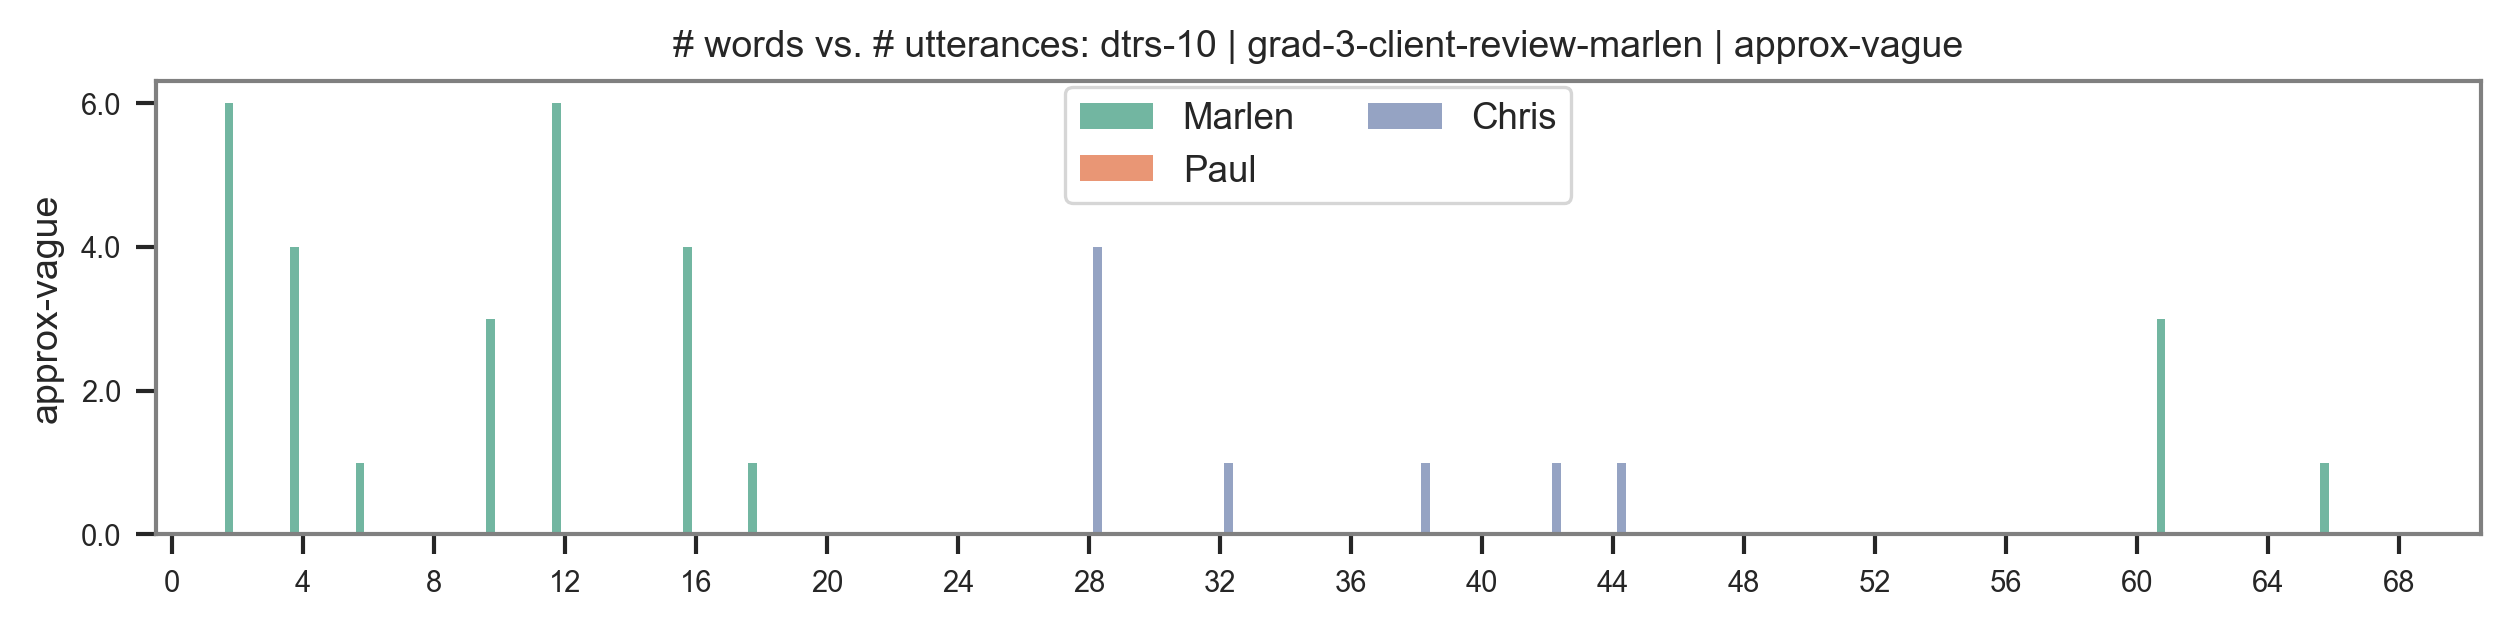

In [31]:
plot_measure(df, 'dtrs-10', 'grad-3-client-review-marlen', liwc_subcat_name)

<ipython-input-11-d5e0bb820a79>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(map(round2, ax.get_yticks()), fontsize=7)


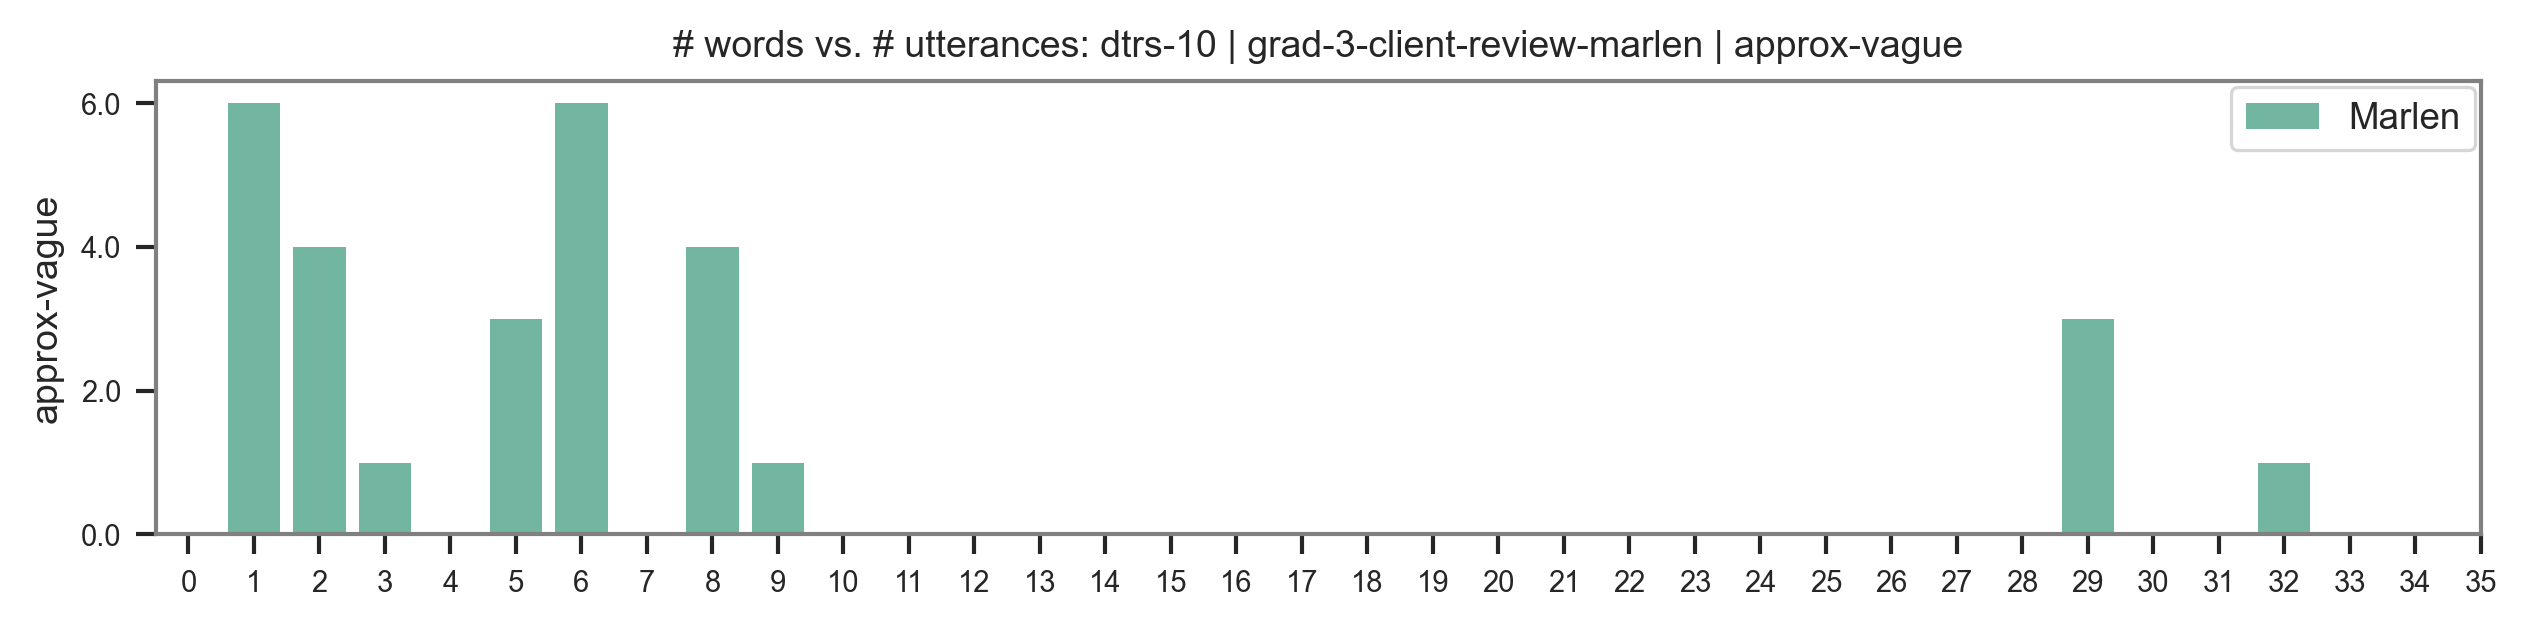

In [32]:
plot_measure(df[df.speaker == 'Marlen'], 'dtrs-10', 'grad-3-client-review-marlen', liwc_subcat_name)

<ipython-input-11-d5e0bb820a79>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(map(round2, ax.get_yticks()), fontsize=7)


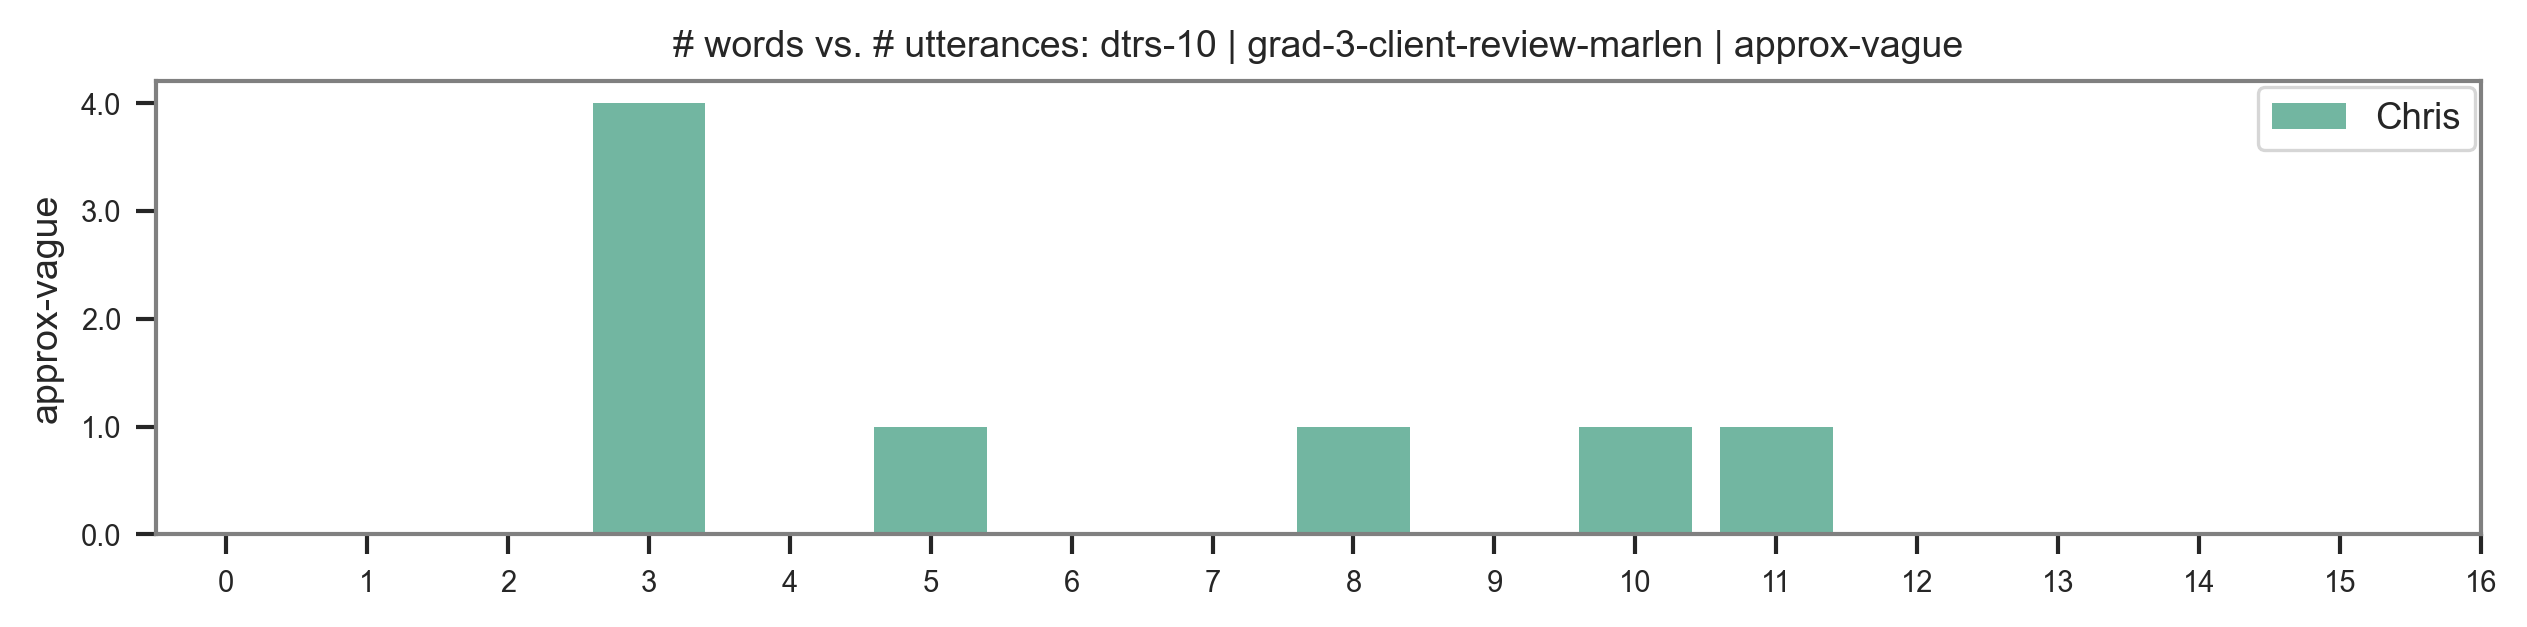

In [33]:
plot_measure(df[df.speaker == 'Chris'], 'dtrs-10', 'grad-3-client-review-marlen', liwc_subcat_name)

In [ ]:
marlen_client_rev_df = df[(df.dataset == 'dtrs-10') & (df.session == 'grad-3-client-review-marlen')]
marlen_client_rev_df[0:10]

In [ ]:
plot_measure(df, 'dtrs-10', 'grad-3-client-review-marlen', liwc_subcat_name)

In [ ]:
print_lines(df, 'dtrs-10', 'grad-3-client-review-marlen', liwc_subcat, 2, num_lines=1)
print_lines(df, 'dtrs-10', 'grad-3-client-review-marlen', liwc_subcat, 4, num_lines=1)
print_lines(df, 'dtrs-10', 'grad-3-client-review-marlen', liwc_subcat, 6, num_lines=1)
print_lines(df, 'dtrs-10', 'grad-3-client-review-marlen', liwc_subcat, 10, num_lines=1)

In [ ]:
plot_measure(df, 'dtrs-10', 'grad-2-concept-review-marlen', liwc_subcat_name)

In [ ]:
print_lines(df, 'dtrs-10', 'grad-2-concept-review-marlen', liwc_subcat, 0, num_lines=1)
print_lines(df, 'dtrs-10', 'grad-2-concept-review-marlen', liwc_subcat, 6, num_lines=1)
print_lines(df, 'dtrs-10', 'grad-2-concept-review-marlen', liwc_subcat, 18, num_lines=1)
print_lines(df, 'dtrs-10', 'grad-2-concept-review-marlen', liwc_subcat, 29, num_lines=1)
print_lines(df, 'dtrs-10', 'grad-2-concept-review-marlen', liwc_subcat, 59, num_lines=1)

In [24]:
anomalies1_df = df[df['session'] == 'grad-1-search-review-marlen-david']

<AxesSubplot:xlabel='speaker', ylabel='count'>

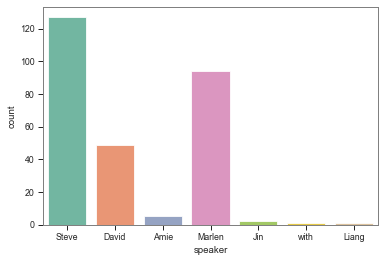

In [25]:
sns.countplot(data=anomalies1_df, x='speaker', palette='Set2')

In [27]:
print(anomalies1_df.shape)
print(anomalies1_df[anomalies1_df.speaker == 'Steve'].shape)
print(anomalies1_df[anomalies1_df.speaker == 'Marlen'].shape)


(279, 5)
(127, 5)
(94, 5)


In [36]:

anomalies2_df = df[df['session'] == 'grad-3-client-review-marlen']

<AxesSubplot:xlabel='speaker', ylabel='count'>

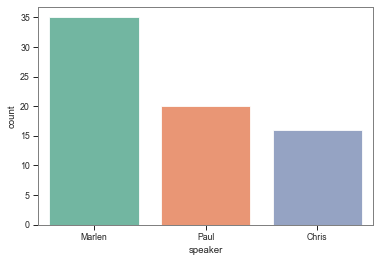

In [37]:
sns.countplot(data=anomalies2_df, x='speaker', palette='Set2')

In [39]:
print(anomalies2_df.shape)
print(anomalies2_df[anomalies2_df.speaker == 'Chris'].shape)
print(anomalies2_df[anomalies2_df.speaker == 'Marlen'].shape)


(71, 5)
(16, 5)
(35, 5)
